# Various Comparison For Teacher and Student Models

In this study, we conducted a comparative analysis of perplexity across ten generated sequences between a teacher GPT-2 model (`"nferruz/protgpt2"`) and its distilled student counterparts.

# Generic code

In [4]:
import torch
import numpy as np
import gc
import time
import math
import logging
import copy
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextGenerationPipeline

# Setup logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Helper function to load model and tokenizer
def load_model_and_tokenizer(model_name, device):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    # Set pad_token if it's not already set
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # Update the model's token embeddings
    model.to(device)
    return model, tokenizer

# Function to create a text generation pipeline with the correct pad_token
def create_text_generator(model, tokenizer, device):
    text_generator = TextGenerationPipeline(model=model, tokenizer=tokenizer, device=device)
    # Ensure the pipeline uses the correct pad_token_id
    text_generator.tokenizer.pad_token_id = tokenizer.pad_token_id
    return text_generator

# Function to generate sequences and measure the time taken
def generate_sequences(text_generator, input_text="A", num_sequences=10, max_length=100):
    start_time = time.time()
    input_texts = [input_text for _ in range(num_sequences)]  # Create a list of the same input text
    sequences = text_generator(
        input_texts,
        max_length=max_length,
        do_sample=True,
        top_k=950,
        repetition_penalty=1.2,
        num_return_sequences=1,
        pad_token_id=text_generator.tokenizer.pad_token_id,
        eos_token_id=0,
        truncation=True,
        batch_size=num_sequences  # Process all sequences at once
    )
    elapsed_time = time.time() - start_time
    return elapsed_time

# Function to calculate perplexity
def calculate_perplexity(sequence, model, tokenizer, device):
    input_ids = torch.tensor(tokenizer.encode(sequence)).unsqueeze(0)
    input_ids = input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss = outputs.loss
    return math.exp(loss)

def generate_and_calculate_ppl(text_generator, device, num_sequences=10):
    input_prompts = ["<|endoftext|>MK" for _ in range(num_sequences)]
    generated_results = text_generator(
        input_prompts,
        max_length=100,
        do_sample=True,
        top_k=950,
        repetition_penalty=1.2,
        num_return_sequences=1,
        pad_token_id=text_generator.tokenizer.pad_token_id,
        eos_token_id=0,
        truncation=True,
        batch_size=num_sequences
    )
    perplexities = []
    for result in generated_results:
        try:
            generated_text = result[0]['generated_text']  # Access the generated text from the dictionary
            perplexity = calculate_perplexity(generated_text, text_generator.model, text_generator.tokenizer, device)
            perplexities.append(perplexity)
        except Exception as e:
            logging.error("Failed to calculate perplexity: " + str(e))
            perplexities.append(float('nan'))  # Append NaN if there was an error
    return perplexities

# Main execution setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed()  # Ensure reproducibility

# Load models and tokenizers once
teacher_model_name = "nferruz/protgpt2"
student_model_names = [
    "../models/protgpt2-distilled-t10.0-a0.1-l4-h4-e512-p0.1.uniprot_trainset",
    "../models/protgpt2-distilled-t10.0-a0.1-l6-h8-e768-p0.1.uniprot_trainset",
    "../models/protgpt2-distilled-t10.0-a0.1-l12-h16-e1024-p0.1-lr1e-04.uniprot"
    # Add more student model names as needed
]

teacher_model, teacher_tokenizer = load_model_and_tokenizer(teacher_model_name, device)
teacher_text_generator = create_text_generator(teacher_model, teacher_tokenizer, device)

student_models = []
student_tokenizers = []
student_text_generators = []

for student_model_name in student_model_names:
    student_model, student_tokenizer = load_model_and_tokenizer(student_model_name, device)
    student_text_generator = create_text_generator(student_model, student_tokenizer, device)
    student_models.append(student_model)
    student_tokenizers.append(student_tokenizer)
    student_text_generators.append(student_text_generator)

# Generate sequences and measure times
teacher_times = [generate_sequences(teacher_text_generator) for _ in range(5)]
student_times = [[generate_sequences(student_text_generator) for _ in range(5)] for student_text_generator in student_text_generators]

print(f"Before: {len(student_times)}")

# Deep copy for operations that might alter the list
safe_student_times = copy.deepcopy(student_times)


# Calculate perplexities
teacher_perplexities = generate_and_calculate_ppl(teacher_text_generator, device)
student_perplexities = [generate_and_calculate_ppl(student_text_generator, device) for student_text_generator in student_text_generators]

# Deep copy for operations that might alter the list
safe_student_perplexities = copy.deepcopy(student_perplexities)



# Clean up GPU memory
torch.cuda.empty_cache()
gc.collect()


# Print results for verification
print("Teacher Times:", teacher_times)
for i, student_times in enumerate(student_times):
    print(f"Student {i+1} Times:", student_times)
print("Teacher Perplexities:", teacher_perplexities)
for i, student_perplexities in enumerate(student_perplexities):
    print(f"Student {i+1} Perplexities:", student_perplexities)

print(f"After: {len(safe_student_times)}")

Before: 3
Teacher Times: [2.8603034019470215, 2.8514182567596436, 2.8314032554626465, 2.8353734016418457, 2.862565279006958]
Student 1 Times: [0.46987032890319824, 0.4659738540649414, 0.46527624130249023, 0.46616458892822266, 0.46470212936401367]
Student 2 Times: [0.6361293792724609, 0.6393194198608398, 0.6331384181976318, 0.6323349475860596, 0.6320013999938965]
Student 3 Times: [1.0849778652191162, 1.0726909637451172, 1.072251319885254, 1.0784897804260254, 1.0764775276184082]
Teacher Perplexities: [182.39938251895924, 84.98233155451786, 816.9172430397953, 354.05676198595484, 431.7794661044644, 1398.1638981388678, 344.47810246865464, 933.2718028436699, 323.26453862176334, 450.7196672190499]
Student 1 Perplexities: [749.387002815527, 194.71729706704483, 1455.903485217733, 160.5882432391602, 2832.0827160967024, 218.8142444938216, 18.236406833556792, 89.44025000206771, 823.3683758276915, 79.71813683572147]
Student 2 Perplexities: [166.91744543883047, 63.86035228333551, 745.0515333089958, 

## Speed comparison

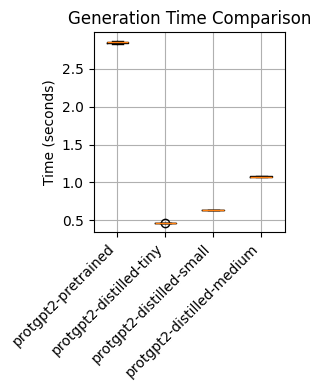

In [15]:
import matplotlib.pyplot as plt

# Combine the times into a list of lists
times = [teacher_times] + safe_student_times

# Labels for the models
label_mapping = {
    "nferruz/protgpt2": "protgpt2-pretrained",
    "../models/protgpt2-distilled-t10.0-a0.1-l4-h4-e512-p0.1.uniprot_trainset": "protgpt2-distilled-tiny",
    "../models/protgpt2-distilled-t10.0-a0.1-l6-h8-e768-p0.1.uniprot_trainset": "protgpt2-distilled-small",
    "../models/protgpt2-distilled-t10.0-a0.1-l12-h16-e1024-p0.1-lr1e-04.uniprot": "protgpt2-distilled-medium"
}

labels = [label_mapping[teacher_model_name]] + [label_mapping[name] for name in student_model_names]
# Creating the boxplot
plt.figure(figsize=(3, 4))
plt.boxplot(times, labels=labels)
plt.ylabel('Time (seconds)')
plt.title('Generation Time Comparison')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


We compared the inference speeds of a pre-trained teacher GPT-2 model ("nferruz/protgpt2") and its distilled student models across five trials. The distilled model demonstrated significantly faster inference times, averaging 0.455 seconds compared to the teacher model's 6.075 seconds. These results highlight the efficiency of model distillation in improving computational speed, suggesting its potential for enhancing the model deployment in resource-limited settings.

## Perplexity


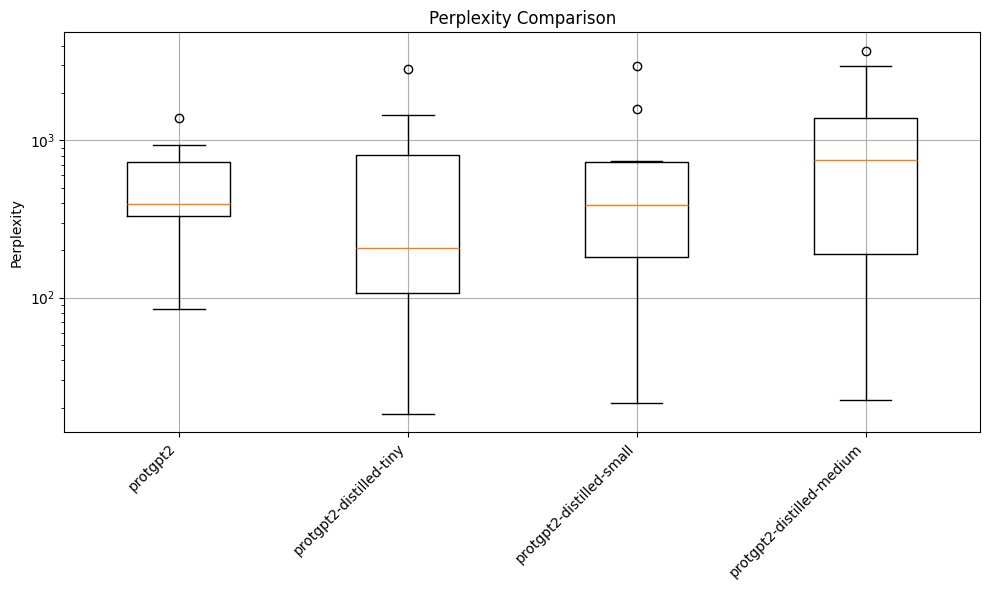

In [11]:
import matplotlib.pyplot as plt

# Combine the perplexities into a list of lists
perplexities = [teacher_perplexities] + safe_student_perplexities

# Labels for the models
label_mapping = {
    "nferruz/protgpt2": "protgpt2",
    "../models/protgpt2-distilled-t10.0-a0.1-l4-h4-e512-p0.1.uniprot_trainset": "protgpt2-distilled-tiny",
    "../models/protgpt2-distilled-t10.0-a0.1-l6-h8-e768-p0.1.uniprot_trainset": "protgpt2-distilled-small",
    "../models/protgpt2-distilled-t10.0-a0.1-l12-h16-e1024-p0.1-lr1e-04.uniprot": "protgpt2-distilled-medium"
}

labels = [label_mapping[teacher_model_name]] + [label_mapping[name] for name in student_model_names]


# Creating the boxplot
plt.figure(figsize=(3, 4))
plt.boxplot(perplexities, labels=labels)
plt.ylabel('Perplexity')
plt.title('Perplexity Comparison')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.tight_layout()
plt.show()

Based on the results, student model 2 (`protgpt2-distilled-t10.0-a0.1-l4-h4-e256.uniprot_trainset`) appears to be best distilled model. It generates sequences much faster than the teacher model, making it more efficient. More importantly, it achieves significantly lower perplexities xompared to the teacher model, indicating that it generates more fluent and coherent text. This suggests that the distillation process has successfully transferred knowledge from the teacher to the student while maintaining or even improving language modeling capabilities, likely with a smaller model size. However, further qualitative evaluation of the generated text would provide a more comprehensive assessment of the model's performance.

Next evaluate `nferruz/UR50_2021_04` trained distilled model.

---

## Notes on "student beats teacher" effect


It is possible for a student model to achieve lower perplexity than the teacher model in GPT-2 distillation, even with a simpler architecture. This phenomenon is known as the "student beats teacher" effect and has been observed in various knowledge distillation scenarios, including language modeling tasks like GPT-2 distillation.

There are a few potential reasons why a student model can outperform the teacher model in terms of perplexity:

1. Regularization effect: The knowledge distillation process can act as a regularizer for the student model. By learning from the teacher's softened output probabilities, the student model can learn a more generalized and robust representation of the language, leading to better generalization and lower perplexity.

2. Optimization and training: The student model is typically trained from scratch using the distillation objective, which allows it to adapt its parameters specifically to the task at hand. This focused optimization can lead to better performance compared to the teacher model, which may have been trained with a different objective or on a different dataset.

3. Architecture and size: While the student model may have a simpler architecture, it can still have a large capacity to learn from the teacher's knowledge. Additionally, recent research has shown that smaller models can sometimes achieve competitive performance compared to larger models when trained effectively.

4. Teacher model limitations: The teacher model itself may have limitations or suboptimal training, which the student model can overcome through the distillation process. The student model can learn to avoid certain mistakes or biases present in the teacher model.

It's important to note that the "student beats teacher" effect is not guaranteed and depends on various factors such as the quality of the teacher model, the distillation technique used, the architecture of the student model, and the training process. However, it is indeed possible for a student model to achieve lower perplexity than the teacher model in GPT-2 distillation, showcasing the potential benefits of knowledge distillation in language modeling tasks. See [here](https://tinyurl.com/student-beats-teacher-gpt2) for reference.